## Import

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import stats
from scipy.optimize import minimize

from datetime import timedelta

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from keras import callbacks
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import matplotlib.pyplot as plt
plt.style.use("bmh")

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline

## Data Load

In [5]:
# Read in price data
train = pd.read_csv("./train.csv", parse_dates=True, index_col="일자")
train = train.reset_index()
train.columns = ['date', 'ticker', 'firm', 'volume', 'open', 'high', 'low', 'close']
train.set_index('date', inplace=True)
train

,ticker,firm,volume,open,high,low,close
date,,,,,,,
2021-06-01,A060310,3S,166690,2890,2970,2885,2920
2021-06-01,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2021-06-01,A006840,AK홀딩스,103691,35500,35600,34150,34400
2021-06-01,A054620,APS,462544,14600,14950,13800,14950
2021-06-01,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...
2023-05-30,A189980,흥국에프엔비,272284,3005,3035,2955,2980
2023-05-30,A000540,흥국화재,50218,3250,3255,3195,3215
2023-05-30,A003280,흥아해운,130664,1344,1395,1340,1370


In [6]:
# Assuming your DataFrame is called 'df'
pivot_df = pd.pivot_table(train, values='close', index='date', columns='ticker')

# Rename the columns based on the ticker names
pivot_df.columns = pivot_df.columns.astype(str)

# Display the resulting DataFrame
pivot_df.head()
print(pivot_df.shape)

(494, 2000)


## 주가를 로그 수익률로 변환

In [7]:
logreturn = np.log(pivot_df / pivot_df.shift(1)).dropna()
logreturn

ticker,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310,A383800
date,,,,,,,,,,,,,,,,,,,,,
2021-06-02,-0.006873,0.029352,0.009983,0.004376,0.012547,-0.013900,-0.005917,0.020943,0.070184,0.035567,...,-0.024912,0.000000,-0.202300,0.006857,0.011050,0.021979,-0.006711,-0.019478,-0.018324,-0.027652
2021-06-03,0.006873,-0.008299,0.019673,0.000000,-0.005000,-0.001556,0.008863,-0.005195,-0.046626,-0.023570,...,-0.018182,0.000000,0.039566,-0.002281,-0.002200,0.007220,-0.010152,0.028573,0.030356,-0.028438
2021-06-04,0.006826,-0.004175,-0.026317,-0.008772,-0.017700,-0.009390,-0.017805,-0.023717,0.025289,-0.011997,...,-0.001837,0.000000,-0.035091,-0.020762,-0.040455,0.003591,0.001699,-0.024441,0.029462,0.004796
2021-06-07,0.030153,0.012474,-0.006689,-0.004415,0.011414,0.003140,-0.002999,0.002663,0.156256,0.013699,...,0.032553,0.000000,-0.027151,-0.009368,-0.004598,0.007143,-0.022319,-0.004132,-0.003878,0.032944
2021-06-08,-0.006623,0.004124,0.010017,0.000000,0.001260,0.000000,0.008969,0.005305,-0.039609,-0.001702,...,0.003552,0.000000,-0.027909,-0.007084,-0.020955,0.000000,-0.012227,0.009274,-0.003894,0.013793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,0.051455,-0.015353,-0.002889,0.000000,-0.004193,0.020203,0.013150,-0.006244,-0.006198,-0.004951,...,-0.003683,0.037740,-0.022389,0.001022,0.001020,0.019284,-0.010605,0.019048,-0.001574,-0.003595
2023-05-24,-0.003075,0.025001,0.000000,0.001331,0.002099,-0.005013,0.016490,0.022705,0.025577,0.004951,...,0.003683,-0.035339,-0.035855,0.003569,-0.019558,0.006798,0.037661,-0.024983,0.006279,-0.003608
2023-05-25,0.030336,-0.033476,0.000964,-0.009352,-0.006309,-0.006723,-0.030845,-0.013354,0.000000,-0.012923,...,-0.012020,0.078381,-0.037189,-0.014868,-0.021009,-0.016394,-0.054866,-0.015748,0.039883,0.001204


In [8]:
# args 정하기
N_STOCKS = 2000
N_TIME = 60
N_FUTURE = 20
TEST_RANGE = N_TIME + N_FUTURE

In [9]:
train, test = train_test_split(logreturn, test_size=0.2, shuffle=False)

In [10]:
def get_splitted_data(dataset, dataset_len, TEST_RANGE, COV_SEARCH):
    xc = np.empty((dataset_len - TEST_RANGE, COV_SEARCH, N_STOCKS))
    xf = np.empty((dataset_len - TEST_RANGE, N_FUTURE, N_STOCKS))

    for idx in range(dataset_len - TEST_RANGE):
        temp_xc = dataset[idx : idx + COV_SEARCH]
        temp_xf = dataset[idx + COV_SEARCH : idx + TEST_RANGE]

        xc[idx] = temp_xc
        xf[idx] = temp_xf

    return xc, xf

train_len = len(train)
test_len = len(test)

xc_train, xf_train = get_splitted_data(train, train_len, TEST_RANGE, N_TIME)
xc_test, xf_test = get_splitted_data(test, test_len, TEST_RANGE, N_TIME)

xc_train, xf_train = shuffle(xc_train, xf_train)


In [14]:
# Define the hyperparameters
GAMMA_CONST = 0.0
REG_CONST = 0.0
NUM_LONG_SHORT_STOCKS = 200

# Define the Markowitz objective
def markowitz_objective(y_true, y_pred):
    W = y_pred      
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST

    objective = rtn - vol - reg

    return -tf.reduce_mean(objective, axis=0)

# Build the Markowitz model using LSTM
xc_input = tf.keras.Input(batch_shape=(None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.5, kernel_regularizer=l2(0.005))(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)

# The final weights of the Markowitz portfolio
model = tf.keras.Model(xc_input, y_output)

# Train the MPN and save the results
SAVE_MODEL = 'Markowitz_network_final'
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss=markowitz_objective, optimizer=Adam(learning_rate=1e-5))
hist = model.fit(xc_train, xf_train, epochs=1000, batch_size=32, validation_data=(xc_test, xf_test), callbacks=[early_stopping])
model.save(SAVE_MODEL + '.h5')

Epoch 1/1000
10/10 [==============================] - 1s 37ms/step - loss: 2.2642 - val_loss: 2.2574
Epoch 2/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.2507 - val_loss: 2.2443
Epoch 3/1000
10/10 [==============================] - 0s 13ms/step - loss: 2.2373 - val_loss: 2.2314
Epoch 4/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.2241 - val_loss: 2.2185
Epoch 5/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.2107 - val_loss: 2.2057
Epoch 6/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.1974 - val_loss: 2.1929
Epoch 7/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.1844 - val_loss: 2.1802
Epoch 8/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.1713 - val_loss: 2.1676
Epoch 9/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.1585 - val_loss: 2.1551
Epoch 10/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.1455 - val_lo

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

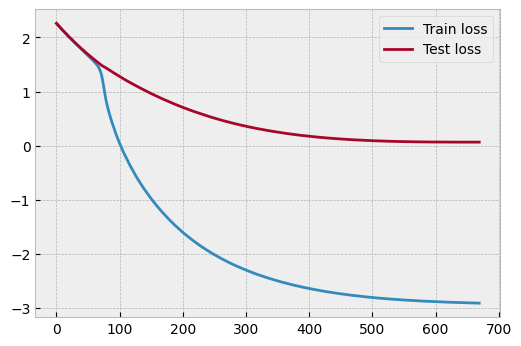

1/1 [==============================] - 0s 149ms/step


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

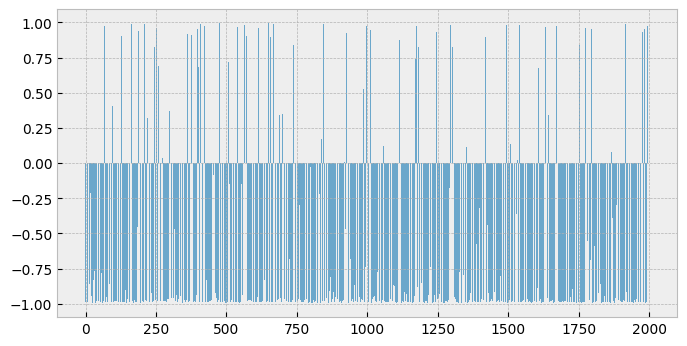

In [15]:
# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 조회용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [ ]:
# Post-processing weights
weights = model.predict(some_input)

# Sort indices of weights
sorted_indices = np.argsort(weights)

# Long positions: top 200 positive weights
long_positions = sorted_indices[-NUM_LONG_SHORT_STOCKS:]

# Short positions: top 200 negative weights
short_positions = sorted_indices[:NUM_LONG_SHORT_STOCKS]

# Initialize new weights as all zeros.
new_weights = np.zeros_like(weights)

# Set the positions
new_weights[long_positions] = 1    # Long positions
new_weights[short_positions] = -1    # Short positions

## Model Define, Train and Inference

In [47]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# For this example, let's say we are only interested in close prices
prices = pivot_df

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
raw_weights = ef.max_sharpe()

# Get the cleaned weights for the portfolio
cleaned_weights = ef.clean_weights()

In [49]:
# Sort the weights
sorted_weights = {k: v for k, v in sorted(cleaned_weights.items(), key=lambda item: item[1], reverse=True)}

# Get the top 200 to go long
long_stocks = {k: sorted_weights[k] for k in list(sorted_weights.keys())[:200]}

# Get the bottom 200 to go short
short_stocks = {k: sorted_weights[k] for k in list(sorted_weights.keys())[-200:]}

print("Long these stocks: ", long_stocks)
print("Short these stocks: ", short_stocks)

Long these stocks:  {'A101670': 1.0, 'A086520': 0.69296, 'A073570': 0.65318, 'A001570': 0.60918, 'A114190': 0.56709, 'A002710': 0.49498, 'A005070': 0.4774, 'A006110': 0.46005, 'A035290': 0.44577, 'A010580': 0.41329, 'A002900': 0.40145, 'A009730': 0.40007, 'A277810': 0.38058, 'A108860': 0.37246, 'A003280': 0.36514, 'A042600': 0.34355, 'A095500': 0.34082, 'A222810': 0.34009, 'A234920': 0.33763, 'A007660': 0.33492, 'A121600': 0.33136, 'A029480': 0.32062, 'A281740': 0.31987, 'A005420': 0.30351, 'A317770': 0.30293, 'A336570': 0.29897, 'A085670': 0.2989, 'A178780': 0.29445, 'A106080': 0.28515, 'A182360': 0.27726, 'A003620': 0.27539, 'A096610': 0.27227, 'A005950': 0.24823, 'A006740': 0.2477, 'A007120': 0.24698, 'A035900': 0.24613, 'A064550': 0.24085, 'A001080': 0.23879, 'A214370': 0.23738, 'A011300': 0.22908, 'A173130': 0.22719, 'A003610': 0.22536, 'A093640': 0.22397, 'A035080': 0.22282, 'A145720': 0.21821, 'A058610': 0.21388, 'A335890': 0.21241, 'A093520': 0.20933, 'A041510': 0.20761, 'A0520

## Submit

In [54]:
# Create a dictionary with rankings
ranked_weights = {k: rank for rank, k in enumerate(sorted_weights.keys(), 1)}

# Convert to DataFrame
df_ranked = pd.DataFrame(list(ranked_weights.items()),columns = ['종목코드','순위']) 

# Save as csv
df_ranked.to_csv('ranked_weights.csv', index=False)
df_ranked

,종목코드,순위
0,A101670,1
1,A086520,2
2,A073570,3
3,A001570,4
4,A114190,5
...,...,...
1995,A016590,1996
1996,A183490,1997
1997,A005800,1998
1998,A181340,1999


In [55]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission

,종목코드,순위
0,A000020,1
1,A000040,2
2,A000050,3
3,A000070,4
4,A000080,5
...,...,...
1995,A375500,1996
1996,A378850,1997
1997,A383220,1998
1998,A383310,1999


In [56]:
baseline_submission = sample_submission[['종목코드']].merge(df_ranked[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission

,종목코드,순위
0,A000020,922
1,A000040,1314
2,A000050,1005
3,A000070,1278
4,A000080,1487
...,...,...
1995,A375500,1917
1996,A378850,931
1997,A383220,1952
1998,A383310,1940


In [57]:
baseline_submission.to_csv('baseline_submission.csv', index=False)